In [1]:

%pprint
%matplotlib inline
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
import matplotlib.dates as mdates

Pretty printing has been turned OFF
======== Neo4j/4.4.7 ========
Utility libraries created in 11 seconds


In [2]:

# Cypher for job hunting activity since the beginning of recorded history
cypher_str = '''
    // Count job hunting activity since the beginning of recorded history
    CALL {
        MATCH (fn:FileNames)
        WHERE (fn.rejection_email_date <= date())
        RETURN
            fn.rejection_email_date AS action_date,
            0 AS application_count,
            COUNT(fn.rejection_email_date) AS rejection_count
        UNION
        MATCH (fn:FileNames)
        WHERE (fn.opportunity_application_email_date <= date())
        RETURN
            fn.opportunity_application_email_date AS action_date,
            COUNT(fn.opportunity_application_email_date) AS application_count,
            0 AS rejection_count
    }
    WITH action_date, SUM(application_count) AS total_applications, SUM(rejection_count) AS total_rejections
    RETURN
        action_date,
        total_applications,
        total_rejections
    ORDER BY action_date ASC;'''

In [3]:

# Cypher for job hunting activity since last day of work
cypher_str = '''
    // Count job hunting activity since last day of work
    CALL {
        MATCH (fn:FileNames)
        WHERE ((fn.rejection_email_date <= date()) AND (fn.rejection_email_date >= date("2024-06-13")))
        RETURN
            fn.rejection_email_date AS action_date,
            0 AS application_count,
            COUNT(fn.rejection_email_date) AS rejection_count
        UNION
        MATCH (fn:FileNames)
        WHERE ((fn.opportunity_application_email_date <= date()) AND (fn.opportunity_application_email_date >= date("2024-06-13")))
        RETURN
            fn.opportunity_application_email_date AS action_date,
            COUNT(fn.opportunity_application_email_date) AS application_count,
            0 AS rejection_count
    }
    WITH action_date, SUM(application_count) AS total_applications, SUM(rejection_count) AS total_rejections
    RETURN
        action_date,
        total_applications,
        total_rejections
    ORDER BY action_date ASC;'''

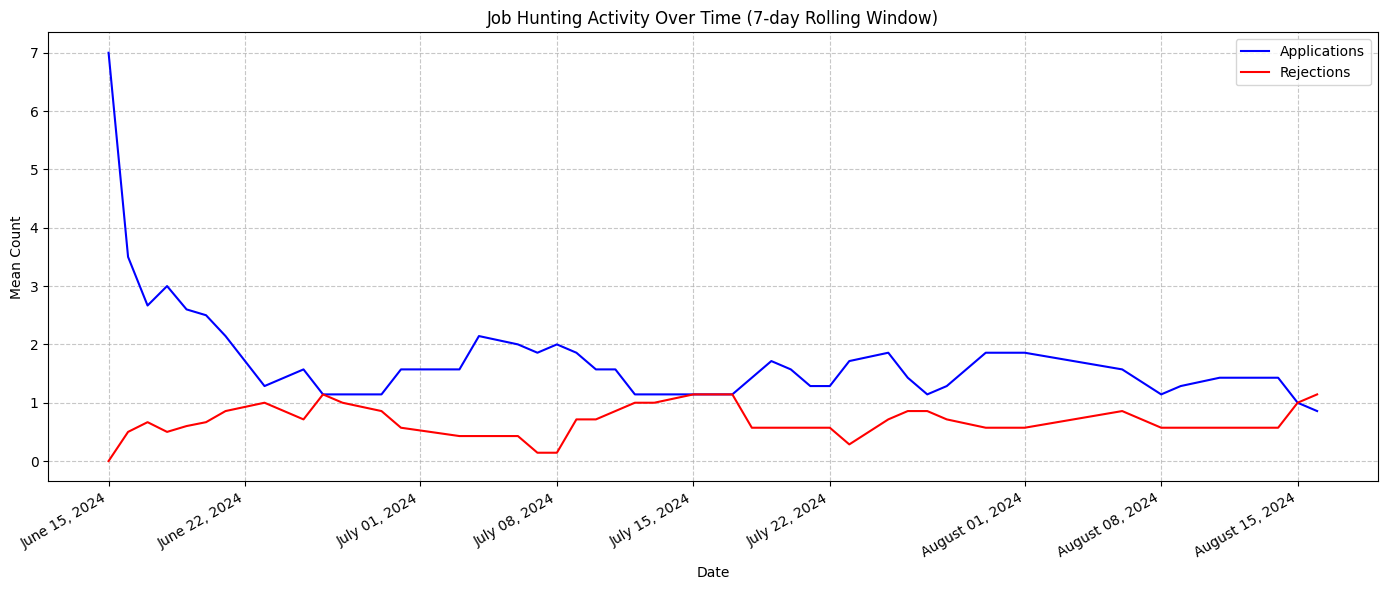

In [4]:

# Count job hunting activity since last day of work
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list).set_index('action_date')
    
    # Convert neo4j.time.Date to Python date
    df.index = [date(d.year, d.month, d.day) for d in df.index]
    
    # Now convert to datetime
    df.index = pd.to_datetime(df.index)
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(14, 6))  # Increased width to accommodate longer labels
    
    # Plot the data
    window = 7
    min_periods = 1
    ax.plot(df.index, df['total_applications'].rolling(window=window, min_periods=min_periods).mean(), label='Applications', color='blue')
    ax.plot(df.index, df['total_rejections'].rolling(window=window, min_periods=min_periods).mean(), label='Rejections', color='red')
    
    # Customize the plot
    ax.set_title(f'Job Hunting Activity Over Time ({window}-day Rolling Window)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Count')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis ticks
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %B %d'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d, %Y'))
    # ax.xaxis.set_major_locator(mdates.DayLocator())
    
    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    # Adjust layout to prevent cutting off labels
    fig.tight_layout()
    
    # Show the plot
    plt.show()

In [5]:

total_applications = df.sum().total_applications
total_rejections = df.sum().total_rejections
mask_series = (df.index == datetime.now().strftime('%Y-%m-%d'))
if mask_series.any():
    todays_applications = df[mask_series].total_applications.squeeze()
    todays_rejections = df[mask_series].total_rejections.squeeze()
else:
    todays_applications = 0
    todays_rejections = 0
print(
    f'I applied to {todays_applications} jobs and got {todays_rejections} rejections today, for a total of {total_applications} applications and {total_rejections} rejections since my contract ended.'
)

I applied to 0 jobs and got 1 rejections today, for a total of 69 applications and 33 rejections since my contract ended.


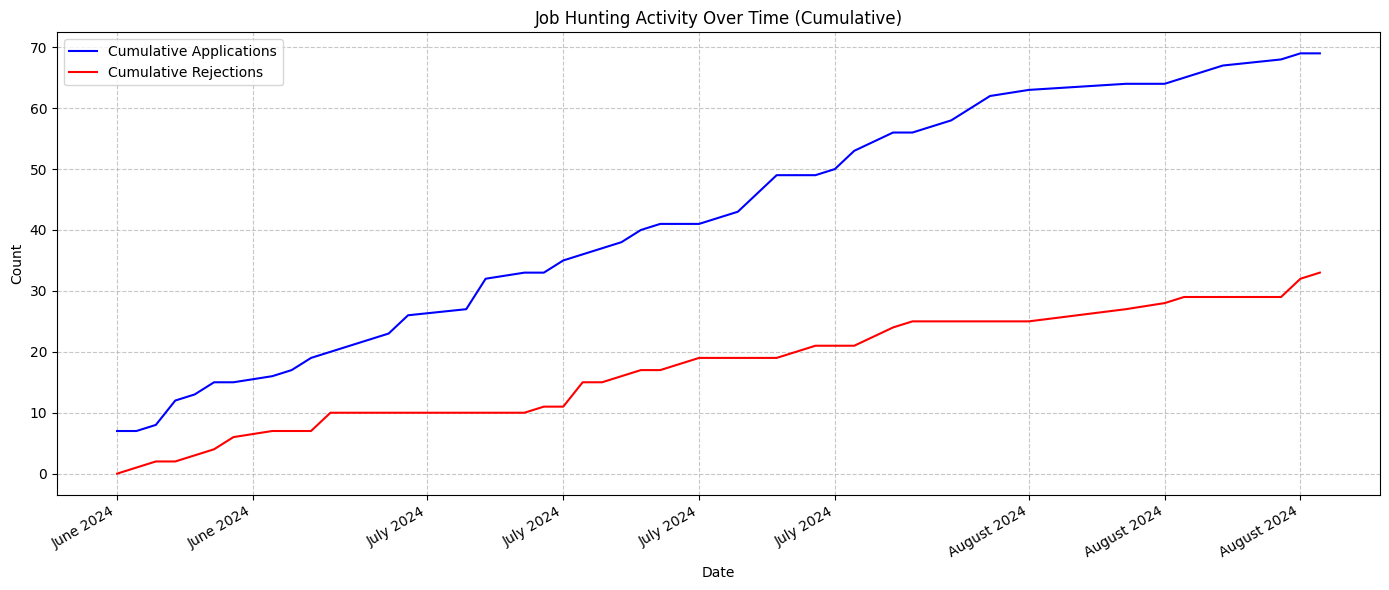

In [6]:

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(14, 6))  # Increased width to accommodate longer labels

# Plot the data
ax.plot(df.cumsum().index, df.cumsum()['total_applications'], label='Cumulative Applications', color='blue')
ax.plot(df.cumsum().index, df.cumsum()['total_rejections'], label='Cumulative Rejections', color='red')

# Customize the plot
ax.set_title('Job Hunting Activity Over Time (Cumulative)')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Format x-axis ticks
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %B %d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
# ax.xaxis.set_major_locator(mdates.DayLocator())

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

In [7]:

# Check if the lru has built its is-qualified classifier
t1 = time.time()
if not (hasattr(lru, 'ISQUALIFIED_LR') and hasattr(lru, 'ISQUALIFIED_CV')):
    lru.build_isqualified_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Is-qualified LR elements built in {duration_str}'; print(speech_str)

I have 424,879 is-qualified vocabulary tokens in here
Is-qualified LR elements built in 6 seconds


I have 18,301 hand-labeled qualification strings in here
I have 514,511 is-qualified vocabulary tokens in here
Is-qualified classifer retrained in 1 minute and 47 seconds


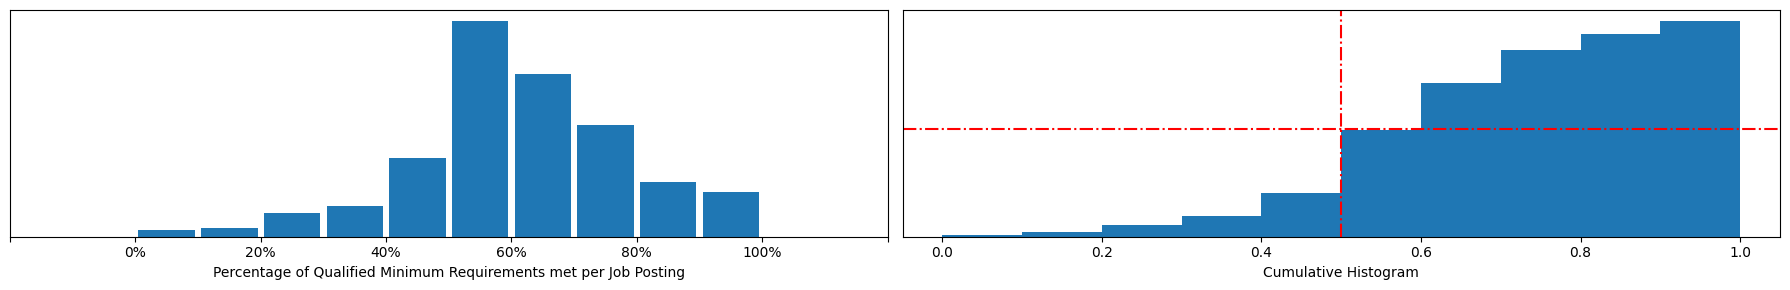

In [8]:

# You need to run this again if you changed the
# qualification dictionary below or in another notebook
t1 = time.time()

# Keep the total retraining time to less than two minutes by adjusting the sampling strategy limit
lru.sync_basic_quals_dict(sampling_strategy_limit=None, verbose=False)

lru.retrain_isqualified_classifier(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Is-qualified classifer retrained in {duration_str}'; print(speech_str)
lru.display_hunting_dataframe_as_histogram()